In [1]:
!pip install ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=1eba00410d7da61a2c3fff325d1abb8153333fe8f99d655b3ba430f4e8ab1ef3
  Stored in directory: /root/.cache/pip/wheels/5f/67/4f/8a9f252836e053e532c6587a3230bc72a4deb16b03a829610b
Successfully built ta


In [39]:
# import the necessary libraries/modules
import ta
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [3]:
# constants
stop_loss_multiplier = 1 # change between 1.0 and 1.5
risk_reward_ratio = 2.0
# Calculate the ATR (used to determine stop loss distance)
atr_period = 14
adx_period = 14  # Common period for ADX is 14

In [27]:
## load the dataset!
df = pd.read_csv('BTCUSD_M15.csv')
df.head()

,Date,Open,High,Low,Close,Vol
0,06/10/2021 05:45,51342.9,51562.4,51330.5,51482.2,1
1,06/10/2021 06:00,51476.6,51552.7,51426.6,51497.2,1
2,06/10/2021 06:15,51496.3,51625.2,51479.6,51598.4,1
3,06/10/2021 06:30,51596.1,51682.4,51554.4,51585.5,1
4,06/10/2021 06:45,51584.0,51607.2,51484.0,51488.1,1


In [28]:
def data_cleaning(df):
  if 'Vol' in df.columns:
    del df['Vol']
  if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y %H:%M')
    df.set_index('Date', inplace=True)
  df['sma_6'] = ta.trend.SMAIndicator(df['Close'], window=6).sma_indicator()
  df['sma_20'] = ta.trend.SMAIndicator(df['Close'], window=20).sma_indicator()
  df['sma_100'] = ta.trend.SMAIndicator(df['Close'], window=100).sma_indicator()
  df['adx'] = ta.trend.ADXIndicator(high=df['High'], low=df['Low'], close=df['Close'], window=adx_period).adx()
  df['bb_width'] = ta.volatility.BollingerBands(df['Close'], window=20, window_dev=2).bollinger_wband()
  df['bb_pband'] = ta.volatility.BollingerBands(df['Close'], window=20, window_dev=2).bollinger_pband()
  df['trend'] = np.where(df['Close'] > df['sma_100'], 1, 2)
# Check for crossover (SMA-6 crosses above SMA-20)
  df['crossover'] = ((df['sma_6'] > df['sma_20']) & (df['sma_6'].shift(1) <= df['sma_20'].shift(1))).astype(int)

# Check for crossunder (SMA-6 crosses below SMA-20)
  df['crossunder'] = ((df['sma_6'] < df['sma_20']) & (df['sma_6'].shift(1) >= df['sma_20'].shift(1))).astype(int)

# Only consider crossovers/crossunders in the direction of the trend
  df['valid_cross'] = np.where(df['crossover'],1,
                             np.where(df['crossunder'],2,3))
  df['ATR'] = ta.volatility.AverageTrueRange(df['High'], df['Low'], df['Close'], window=atr_period).average_true_range()
# Calculate initial stop loss and take profit levels
  df['LowerStopLoss'] = df['Low'] - (df['ATR'] * stop_loss_multiplier)
  df['UpperStopLoss'] = df['High'] + (df['ATR'] * stop_loss_multiplier)

  # Calculate the take profit based on risk-reward ratio (2x the distance from stop loss)
  df['LowerTakeProfit'] = df['Close'] - ((df['UpperStopLoss'] - df['Close']) * risk_reward_ratio)
  df['UpperTakeProfit'] = df['Close'] + ((df['Close'] - df['LowerStopLoss']) * risk_reward_ratio)
  df.dropna(inplace=True)

  return df

In [29]:
df = data_cleaning(df)
df.head()

,Open,High,Low,Close,sma_6,sma_20,sma_100,adx,bb_width,bb_pband,trend,crossover,crossunder,valid_cross,ATR,LowerStopLoss,UpperStopLoss,LowerTakeProfit,UpperTakeProfit
Date,,,,,,,,,,,,,,,,,,,
2021-10-07 06:30:00,54691.4,54691.4,54492.9,54498.1,54667.016667,54848.09,53773.157,13.196027,1.248902,-0.010935,1,0,0,3,250.025805,54242.874195,54941.425805,53611.448390,55008.551610
2021-10-07 06:45:00,54496.9,54622.4,54364.4,54488.3,54630.333333,54835.45,53803.218,13.608975,1.365987,0.036543,1,0,0,3,250.595390,54113.804610,54872.995390,53718.909219,55237.290781
2021-10-07 07:00:00,54488.3,54552.6,54228.2,54291.0,54575.150000,54805.57,53831.156,14.481079,1.613190,-0.082015,1,0,0,3,255.867148,53972.332852,54808.467148,53256.065704,54928.334296
2021-10-07 07:15:00,54287.7,54563.4,54269.3,54547.3,54551.333333,54780.60,53860.645,15.226554,1.610692,0.235592,1,0,0,3,258.598066,54010.701934,54821.998066,53997.903868,55620.496132
2021-10-07 07:30:00,54547.1,54734.8,54532.5,54652.5,54528.066667,54763.79,53891.315,14.946098,1.584015,0.371707,1,0,0,3,254.576776,54277.923224,54989.376776,53978.746449,55401.653551


In [30]:
def evaluate_trades_precisely(df):
    df['trade_result'] = 0
    # df['trade_duration'] = 0
    i = 0

    while i < len(df):
        if df['valid_cross'].iloc[i] == 1:  # Long trade signal
            entry_price = df['Close'].iloc[i]
            stop_loss = df['LowerStopLoss'].iloc[i]
            take_profit = df['UpperTakeProfit'].iloc[i]

            for j in range(i, len(df)):
                if df['Low'].iloc[j] <= stop_loss:
                    df.loc[df.index[i], 'trade_result'] = 3  # Stop loss hit
                    # df.loc[df.index[i], 'trade_duration'] = j - i
                    # i = j  # Move outer loop to this point
                    break
                elif df['High'].iloc[j] >= take_profit:
                    df.loc[df.index[i], 'trade_result'] = 1  # Take profit hit
                    # df.loc[df.index[i], 'trade_duration'] = j - i
                    # i = j  # Move outer loop to this point
                    break
            else:
                # Trade didn't conclude within available data
                df.loc[df.index[i], 'trade_result'] = -1
                # df.loc[df.index[i], 'trade_duration'] = len(df) - i - 1

        elif df['valid_cross'].iloc[i] == 2:  # Short trade signal
            entry_price = df['Close'].iloc[i]
            stop_loss = df['UpperStopLoss'].iloc[i]
            take_profit = df['LowerTakeProfit'].iloc[i]

            for j in range(i, len(df)):
                if df['High'].iloc[j] >= stop_loss:
                    df.loc[df.index[i], 'trade_result'] = 3  # Stop loss hit
                    # df.loc[df.index[i], 'trade_duration'] = j - i
                    # i = j  # Move outer loop to this point to avoid repeating trades
                    break
                elif df['Low'].iloc[j] <= take_profit:
                    df.loc[df.index[i], 'trade_result'] = 2  # Take profit hit
                    # df.loc[df.index[i], 'trade_duration'] = j - i
                    # i = j  # Move outer loop to this point to avoid repeating trades
                    break
            else:
                # Trade didn't conclude within available data
                df.loc[df.index[i], 'trade_result'] = -1
                # df.loc[df.index[i], 'trade_duration'] = len(df) - i - 1

        i += 1  # Move to next candle if no trade was initiated

    return df

# Assuming df is your dataframe with all the previous calculations
df = evaluate_trades_precisely(df)

# Display summary of trade results
print("Long trades won:", (df['trade_result'] == 1).sum())
print("Short trades won:", (df['trade_result'] == 2).sum())
print("Trades lost:", (df['trade_result'] == 3).sum())
print("Unconcluded trades:", (df['trade_result'] == -1).sum())

# Calculate win rate
total_concluded_trades = ((df['trade_result'] == 1) | (df['trade_result'] == 2) | (df['trade_result'] == 3)).sum()
winning_trades = (df['trade_result'] == 1).sum() + (df['trade_result'] == 2).sum()
win_rate = winning_trades / total_concluded_trades if total_concluded_trades > 0 else 0
print("Total Signals Taken: ", total_concluded_trades)
print(f"Win rate: {win_rate:.2%}")

# Average trade duration
# avg_duration = df[df['trade_duration'] > 0]['trade_duration'].mean()
# print(f"Average trade duration: {avg_duration:.2f} candles")

Long trades won: 1079
Short trades won: 1120
Trades lost: 4291
Unconcluded trades: 2
Total Signals Taken:  6490
Win rate: 33.88%


In [31]:
df['trade_result'].value_counts()

,count
trade_result,
0,93409
3,4291
2,1120
1,1079
-1,2


In [32]:
len(df)

99901

In [33]:
ml = df[(df['trade_result'] == 1) | (df['trade_result'] == 2) | (df['trade_result'] == 3)]
len(ml)

6490

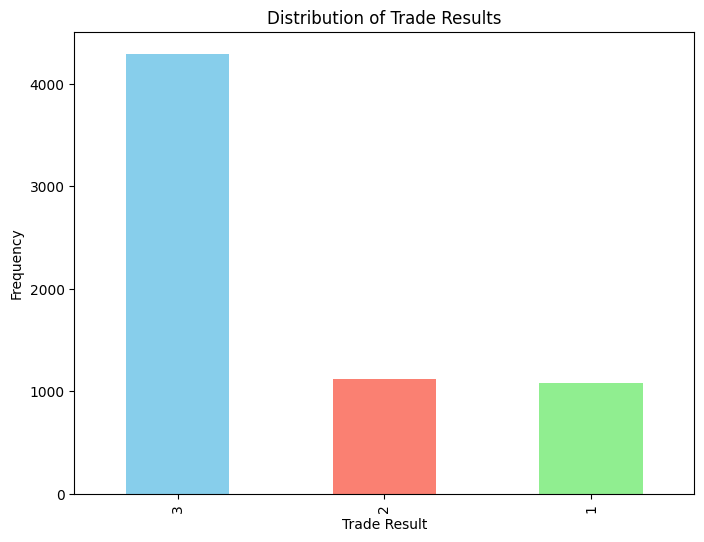

In [34]:
# Plotting
trade_result_counts = ml['trade_result'].value_counts()
plt.figure(figsize=(8, 6))
trade_result_counts.plot(kind='bar', color=['skyblue', 'salmon', 'lightgreen'])
plt.xlabel('Trade Result')
plt.ylabel('Frequency')
plt.title('Distribution of Trade Results')
plt.show()

In [36]:
ml.columns

Index(['Open', 'High', 'Low', 'Close', 'sma_6', 'sma_20', 'sma_100', 'adx',
       'bb_width', 'bb_pband', 'trend', 'crossover', 'crossunder',
       'valid_cross', 'ATR', 'LowerStopLoss', 'UpperStopLoss',
       'LowerTakeProfit', 'UpperTakeProfit', 'trade_result'],
      dtype='object')

In [38]:
x = ml.drop(columns=['trade_result'])  # Features: drop the target column
y = ml['trade_result']  # Target variable

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=42)

# Initialize the RandomForestClassifier
model = RandomForestClassifier(n_estimators=1000, random_state=42)

# Train the model
model.fit(x_train, y_train)

# Make predictions
y_pred = model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

print('Classification Report: \n \n')
print(classification_report(y_test, y_pred))

Accuracy: 0.66
Classification Report: 
 

              precision    recall  f1-score   support

           1       0.44      0.17      0.24       260
           2       0.43      0.19      0.27       271
           3       0.69      0.89      0.78      1092

    accuracy                           0.66      1623
   macro avg       0.52      0.41      0.43      1623
weighted avg       0.61      0.66      0.61      1623



In [40]:
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [41]:
with open('random_forest_model.pkl', 'rb') as file:
    model = pickle.load(file)

In [42]:
y_pred = model.predict(x_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.66
